In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('AEP_hourly.csv')

In [4]:
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [10]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [12]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [14]:
print("First few rows of the DataFrame:")
print(df.head())

First few rows of the DataFrame:
             Datetime   AEP_MW
0 2004-12-31 01:00:00  13478.0
1 2004-12-31 02:00:00  12865.0
2 2004-12-31 03:00:00  12577.0
3 2004-12-31 04:00:00  12517.0
4 2004-12-31 05:00:00  12670.0


In [16]:
print("\nDatatype of Datetime column:")
print(df['Datetime'].dtype)


Datatype of Datetime column:
datetime64[ns]


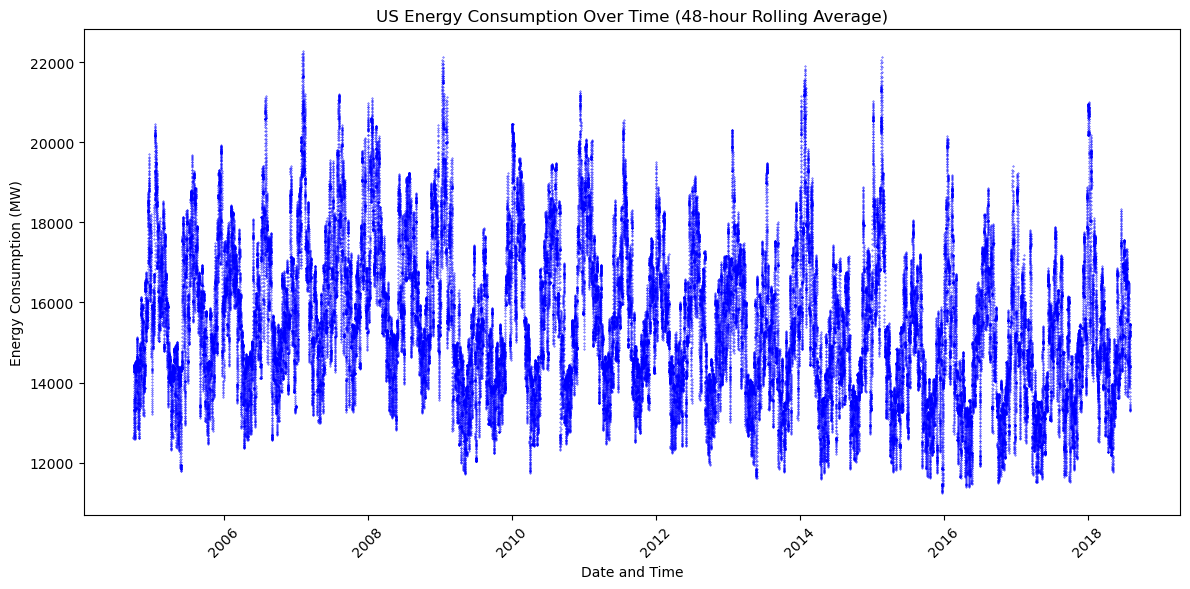

In [18]:
plt.clf()
plt.close('all')

df['rolling_average_48h'] = df['AEP_MW'].rolling(window=48).mean()

# Create a scatter plot with very small points
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['Datetime'], df['rolling_average_48h'], 
           s=0.1,  
           color='blue')

ax.set_title('US Energy Consumption Over Time (48-hour Rolling Average)')
ax.set_xlabel('Date and Time')
ax.set_ylabel('Energy Consumption (MW)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

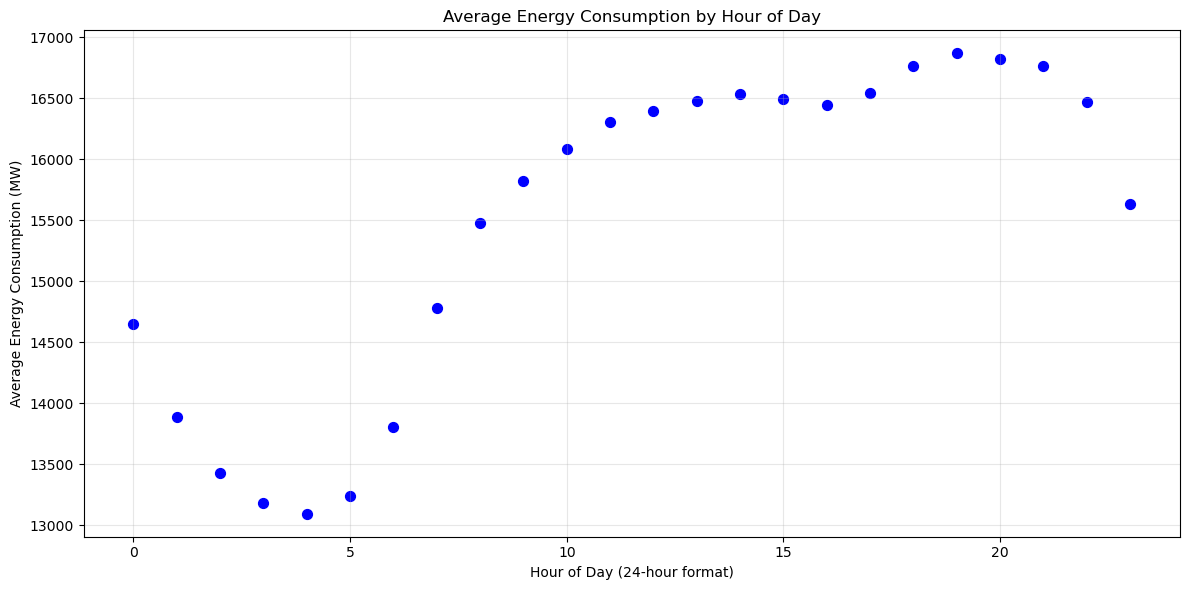

In [20]:
df['hour'] = df['Datetime'].dt.hour

hourly_avg = df.groupby('hour')['AEP_MW'].mean().reset_index()

plt.clf()
plt.close('all')

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(hourly_avg['hour'], hourly_avg['AEP_MW'],
           color='blue', s=50)
ax.set_title('Average Energy Consumption by Hour of Day')
ax.set_xlabel('Hour of Day (24-hour format)')
ax.set_ylabel('Average Energy Consumption (MW)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show

In [22]:
# Basic statistics for each hour
print("Hourly Statistics:")
print(hourly_avg.describe())

# Find peak and minimum hours
peak_hour = hourly_avg.loc[hourly_avg['AEP_MW'].idxmax()]
min_hour = hourly_avg.loc[hourly_avg['AEP_MW'].idxmin()]

print("\nPeak Usage Hour:", peak_hour['hour'])
print("Minimum Usage Hour:", min_hour['hour'])

Hourly Statistics:
            hour        AEP_MW
count  24.000000     24.000000
mean   11.500000  15499.125916
std     7.071068   1349.637181
min     0.000000  13095.193350
25%     5.750000  14461.263285
50%    11.500000  16195.299763
75%    17.250000  16503.273034
max    23.000000  16868.728334

Peak Usage Hour: 19.0
Minimum Usage Hour: 4.0


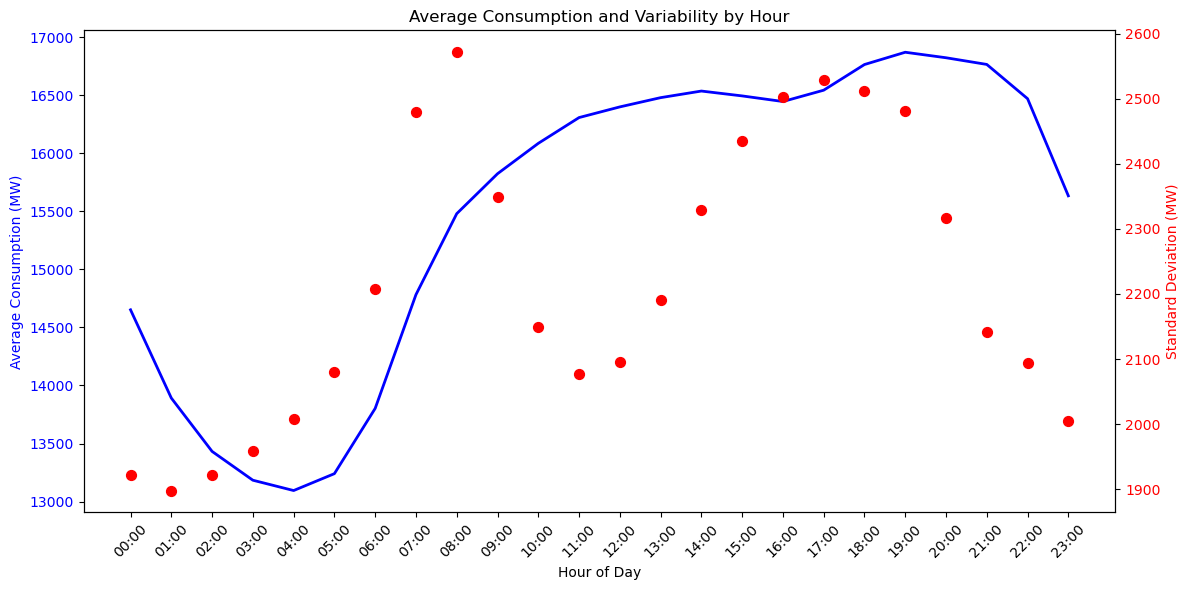

In [24]:
plt.clf()
plt.close('all')

#calculate the mean and STD by hour 

hourly_stats = df.groupby('hour')['AEP_MW'].agg(['mean', 'std']).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'blue'
ax1.plot(hourly_stats['hour'], hourly_stats['mean'], 
         color=color1, 
         label='Mean Consumption',
         linewidth=2)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Consumption (MW)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax1.set_xticks(range(0, 24))
ax1.set_xticklabels([str(i).zfill(2) + ':00' for i in range(24)], rotation=45)

ax2 = ax1.twinx()
color2 = 'red'
ax2.scatter(hourly_stats['hour'], hourly_stats['std'], 
            color=color2, 
            label='Standard Deviation',
            s=50)
ax2.set_ylabel('Standard Deviation (MW)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Average Consumption and Variability by Hour')
plt.tight_layout()
plt.show()

In [26]:
#Prepping data to test statistical significance of peak and off-peak hours 

#Define peak and off-peak
df['is_peak'] = df['hour'].between(7, 22) #True for peak hours 7am - 11pm

#Create comparison groups 
peak_consumption = df[df['is_peak']]['AEP_MW']
offpeak_consumption = df[~df['is_peak']]['AEP_MW']

#Basic statistics 
print("Peak Hours Summary:")
print(peak_consumption.describe())
print("\nOff-Peak Hours Summary:")
print(offpeak_consumption.describe())

Peak Hours Summary:
count    80863.000000
mean     16315.591989
std       2394.368668
min       9701.000000
25%      14602.000000
50%      16038.000000
75%      17890.000000
max      25695.000000
Name: AEP_MW, dtype: float64

Off-Peak Hours Summary:
count    40410.000000
mean     13866.488790
std       2163.731728
min       9581.000000
25%      12214.000000
50%      13519.000000
75%      15209.000000
max      23412.000000
Name: AEP_MW, dtype: float64


In [28]:
#Independent t-test to test statistical significance 

from scipy import stats

#Perform t-test

t_stat, p_value = stats.ttest_ind(peak_consumption, offpeak_consumption)

print("\nT-test Results:")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

#Calculate Cohen's d
effect_size = (peak_consumption.mean() - offpeak_consumption.mean()) / np.sqrt((peak_consumption.var() + offpeak_consumption.var()) / 2)

print(f"Effect size (Cohen's d): {effect_size}")


T-test Results:
t-statistic: 173.27824115440103
p-value: 0.0
Effect size (Cohen's d): 1.0732427023195772


/var/folders/xq/q19k1cdd44v6gzdhh585mk7w0000gn/T/ipykernel_94231/2178651891.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([peak_consumption, offpeak_consumption], labels=['Peak Hours', 'off-Peak hours'])


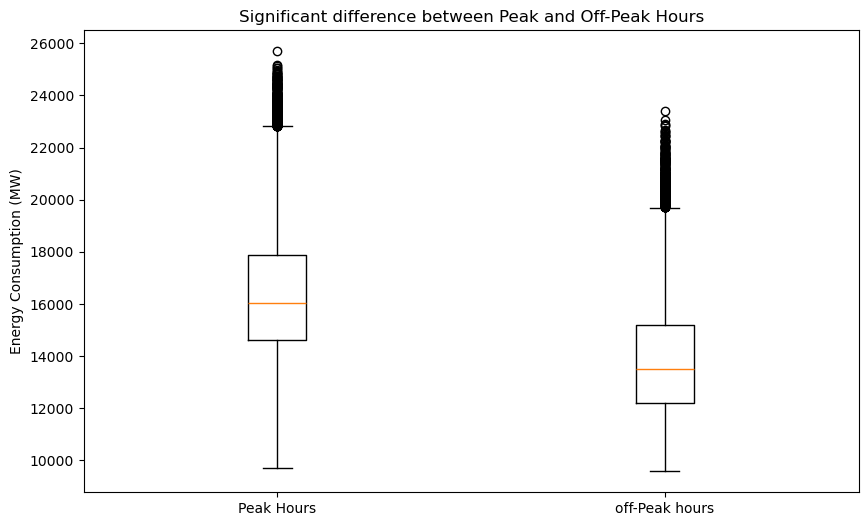

In [30]:
plt.clf()
plt.close('all')

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([peak_consumption, offpeak_consumption], labels=['Peak Hours', 'off-Peak hours'])
ax.set_title('Significant difference between Peak and Off-Peak Hours')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

/var/folders/xq/q19k1cdd44v6gzdhh585mk7w0000gn/T/ipykernel_94231/1300580704.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_avg = df.groupby('season')['AEP_MW'].agg(['mean', 'std']).reset_index()


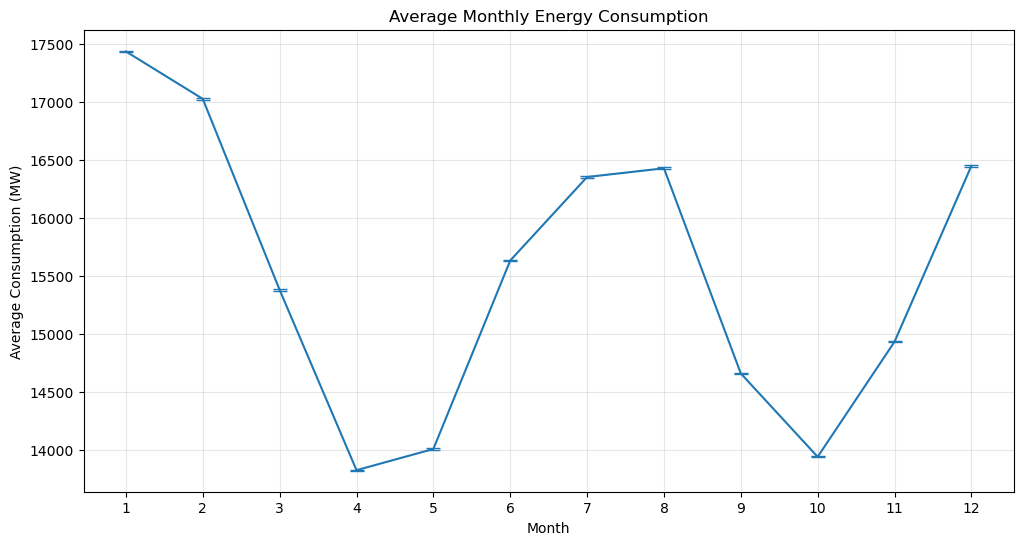


One-way ANOVA Results:
F-statistics: 4183.76
p-value: 0.0000000000


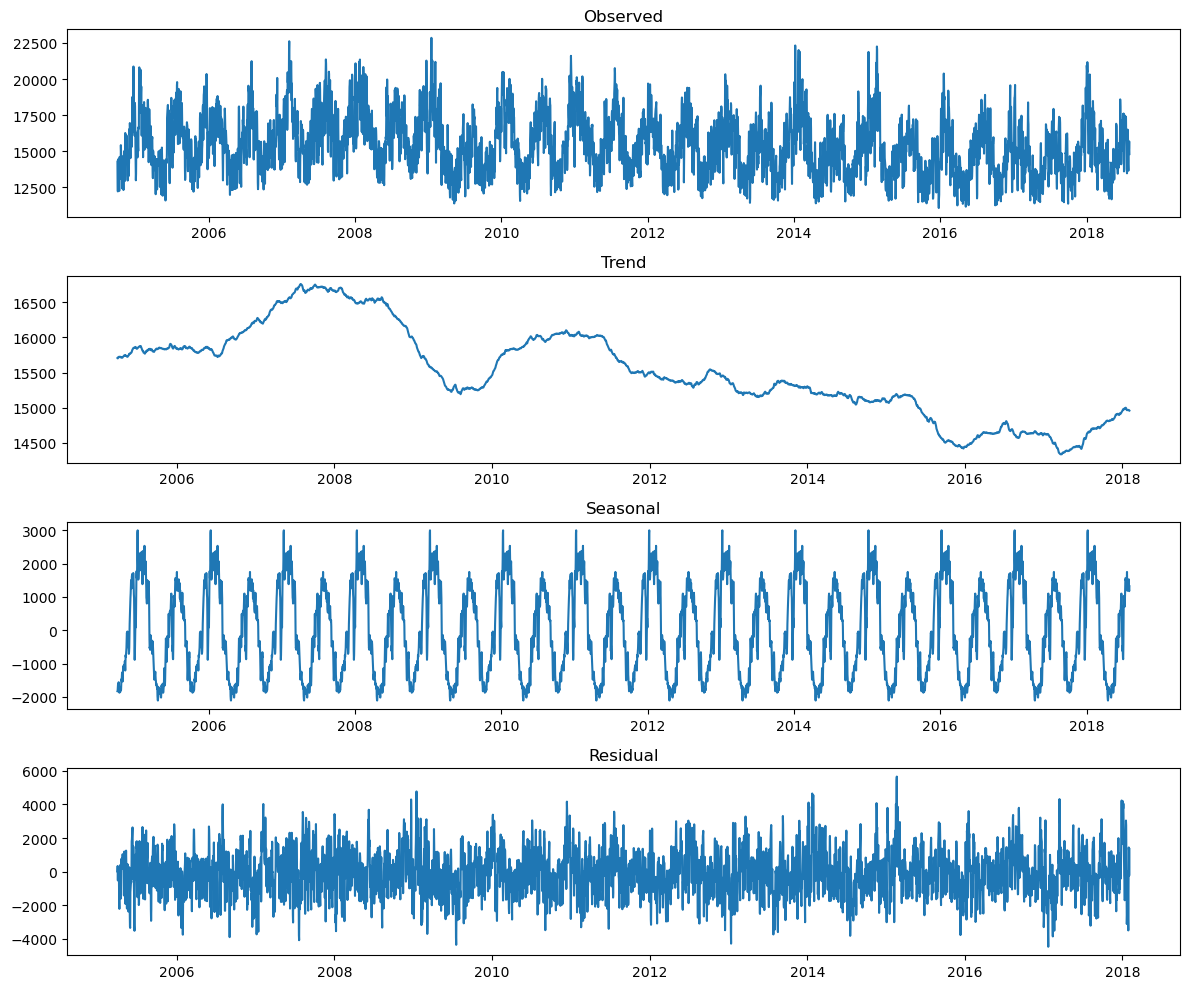


Seasonal Statistics:
   season          mean          std
0  Winter  16598.092577  2328.011969
1  Spring  14481.522012  2348.137086
2  Summer  15837.491711  2966.192840
3    Fall  15106.959616  2171.460760


In [32]:
# Extract month and season from datetime 
df['month'] = df['Datetime'].dt.month
df['season'] = pd.cut(df['Datetime'].dt.month, 
                      bins=[0, 3, 6, 9, 12],
                      labels=['Winter', 'Spring', 'Summer', 'Fall'],
                      include_lowest=True)

# Monthly averages
monthly_avg = df.groupby('month')['AEP_MW'].agg(['mean', 'std']).reset_index()

# Seasonal averages
seasonal_avg = df.groupby('season')['AEP_MW'].agg(['mean', 'std']).reset_index()

# Plotting monthly patterns 
plt.figure(figsize=(12, 6))
plt.errorbar(monthly_avg['month'],
             monthly_avg['mean'],
             yerr=monthly_avg['std']/np.sqrt(len(df)),
             capsize=5)
plt.title('Average Monthly Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Average Consumption (MW)')
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.show()

# One-way ANOVA test for seasonal differences 
seasons_list = [df[df['season'] == season]['AEP_MW'] for season in ['Winter', 'Spring', 'Summer', 'Fall']]
f_stat, p_value = stats.f_oneway(*seasons_list)

print("\nOne-way ANOVA Results:")
print(f"F-statistics: {f_stat:.2f}")
print(f"p-value: {p_value:.10f}")

# Seasonal decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose 

# Resample to daily data for clearer decomposition 
daily_data = df.set_index('Datetime')['AEP_MW'].resample('D').mean()

# Perform seasonal decomposition 
decomposition = seasonal_decompose(daily_data, period=365)

# Plot decomposition 
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

print("\nSeasonal Statistics:")
print(seasonal_avg)                          

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# create Tukey's test 
tukey = pairwise_tukeyhsd(df['AEP_MW'], df['season'])
print("\nTukey's HSD Test Results:")
print(tukey)


Tukey's HSD Test Results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
  Fall Spring -625.4376   0.0  -676.559 -574.3162   True
  Fall Summer  730.5321   0.0  678.9437  782.1205   True
  Fall Winter  1491.133   0.0  1439.895 1542.3709   True
Spring Summer 1355.9697   0.0 1304.2459 1407.6935   True
Spring Winter 2116.5706   0.0 2065.1964 2167.9448   True
Summer Winter  760.6009   0.0  708.7619  812.4398   True
--------------------------------------------------------


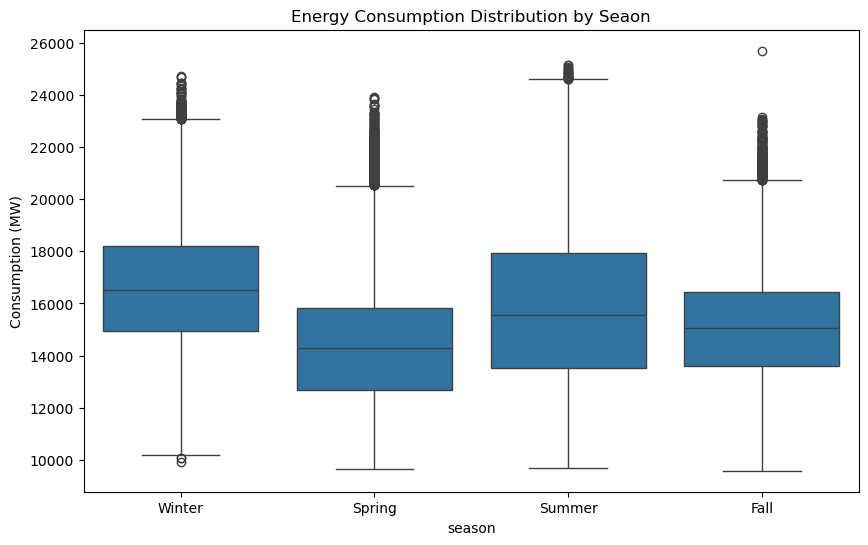

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='AEP_MW', data=df)
plt.title('Energy Consumption Distribution by Seaon')
plt.ylabel('Consumption (MW)')
plt.show()

Yearly Statistics:
    year          mean          std  pct_change
0   2004  15176.724388  2076.669122         NaN
1   2005  15842.990865  2570.898004    4.390055
2   2006  15737.224252  2374.723617   -0.667592
3   2007  16645.519297  2663.611136    5.771634
4   2008  16536.655659  2507.450514   -0.654012
5   2009  15254.111669  2565.914747   -7.755764
6   2010  16008.619504  2752.389911    4.946259
7   2011  15815.389472  2485.742315   -1.207037
8   2012  15352.940667  2410.781638   -2.924043
9   2013  15198.211578  2388.027670   -1.007814
10  2014  15169.078890  2589.014046   -0.191685
11  2015  14868.922603  2613.783648   -1.978738
12  2016  14784.225979  2589.835993   -0.569622
13  2017  14483.738356  2277.453102   -2.032488
14  2018  15290.612734  2526.061868    5.570899


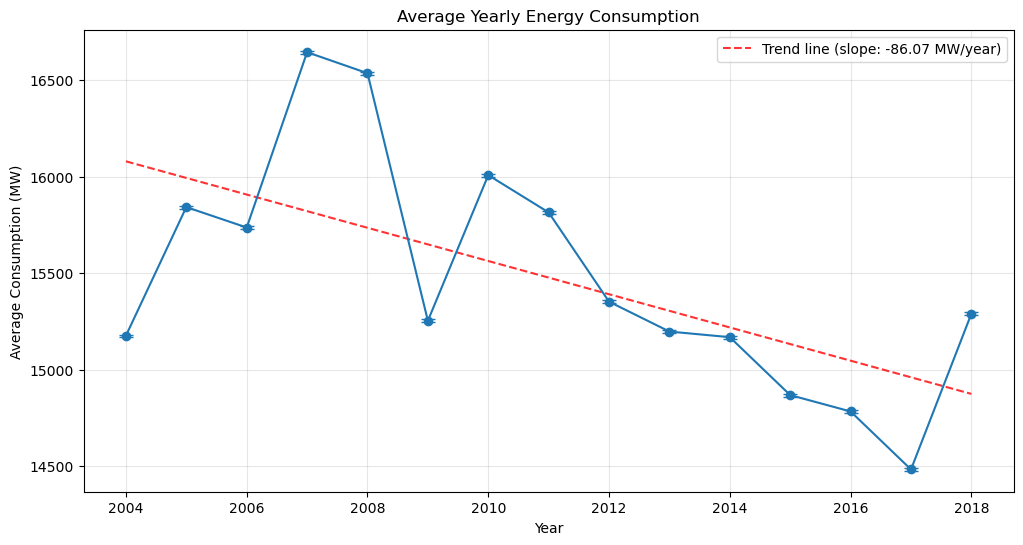


Total change from 2004 to 2018: 0.75%


In [41]:
#Analyze year-over-year decline in energy consumption

#Create year column and calculate yearly averages 
df['year'] = df['Datetime'].dt.year
yearly_avg = df.groupby('year')['AEP_MW'].agg(['mean', 'std']).reset_index()

#Calculate percentage change from previous year 
yearly_avg['pct_change'] = yearly_avg['mean'].pct_change() * 100

#Print yearly statistics 
print("Yearly Statistics:")
print(yearly_avg)

#Create visualization 
plt.figure(figsize=(12, 6))

#plot average consumption by year with error bars 
plt.errorbar(yearly_avg['year'],
             yearly_avg['mean'],
             yerr=yearly_avg['std']/np.sqrt(len(df)),
             capsize=5,
             marker='o')

#add trend line 
z = np.polyfit(yearly_avg['year'], yearly_avg['mean'], 1)
p = np.poly1d(z)
plt.plot(yearly_avg['year'], p(yearly_avg['year']), "r--", alpha=0.8,
         label=f'Trend line (slope: {z[0]:.2f} MW/year)')

plt.title('Average Yearly Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Average Consumption (MW)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#Calculate total percentage change 
total_change = ((yearly_avg['mean'].iloc[-1] - yearly_avg['mean'].iloc[0]) / yearly_avg['mean'].iloc[0] * 100)

print(f"\nTotal change from {yearly_avg['year'].iloc[0]} to {yearly_avg['year'].iloc[-1]}: {total_change:.2f}%")